# 1st part of experiment: Choose the best quantum kernel for XOR binary classification problem

This will be the first part of experiment. In this notebook, I will use Qiskit to simulate quantum kernel with various type of quantum feature map. After benchmark accuracy, I will choose the best quantum feature map for the second part of experiment.

## I. Import libraries

1. Import libraries to generate, split data

In [ ]:
import sys
sys.path.append("Help Function")

import make_data
import time
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2. Import quantum libraries

In [113]:
from qiskit.circuit.library import PauliFeatureMap
from qiskit.primitives import Sampler
from qiskit.primitives.backend_sampler import BackendSampler
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.state_fidelities import ComputeUncompute

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## 2. Make quantum kernel function

Benchmark ZFeatureMap, YFeatureMap, ZZFeatureMap, Angle Encoding, Amplitude Encoding

In [114]:
def noise_model(p = 0.01):
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p, 1), ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p/2, 2), ['cx'])

    return noise_model

In [ ]:
def quantum_kernel(kernel_type, feature_dimension=2, noise = False):
    paulis = []
    match kernel_type:
        case "ZFeatureMap":
            paulis=['Z']
        case "ZZFeatureMap":
            paulis=['ZZ']
        case "Z-ZZFeatureMap":
            paulis = ['Z', 'ZZ']
        case "YFeatureMap":
            paulis = ['Y']
        case "YYFeatureMap":
            paulis = ['YY']
        case 'Y-YYFeatureMap':
            paulis = ['Y', 'YY']
    feature_map = PauliFeatureMap(feature_dimension=feature_dimension, reps=1, paulis=paulis, alpha = 1.0, entanglement="full")

    if noise:
        backend = AerSimulator(noise_model=noise_model(0.01))
        sampler = BackendSampler(backend=backend)
    else:
        sampler = Sampler()
        
    fidelity = ComputeUncompute(sampler=sampler)
    quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)
    
    return quantum_kernel

## 3. Quantum kernel + classical fit

After calculating quantum kernel, we use classical Support Vector Classification (SVC) to fit data, predict data and calculate accuracy

In [116]:
def hybrid_algo(quantum_kernel, data_train, data_test, label_train, label_test):
    start = time.time()

    kernel_train = quantum_kernel.evaluate(x_vec=data_train)
    kernel_test = quantum_kernel.evaluate(x_vec=data_test, y_vec=data_train)

    clf_quantum = SVC(kernel='precomputed')
    clf_quantum.fit(kernel_train, label_train)
    y_pred = clf_quantum.predict(kernel_test)
    acc_quantum = accuracy_score(label_test, y_pred)
    
    end = time.time()

    return acc_quantum, end-start

## 4. Run experiment

I will benchmark through different options
- Kernel option: ZZFeatureMap, ZFeatureMap, YFeatureMap
- Data sizes: [20, 30, ... , 100]
- Rounds: 10 (calculate average to make the result more stable)

In [117]:
data_size = [10*i for i in range(2,11)]
kernel_option = ["Z-ZZFeatureMap", "ZZFeatureMap", "ZFeatureMap", "Y-YYFeatureMap", "YYFeatureMap", "YFeatureMap"]
results = []
rounds = 10

for size in data_size:
    accuracies = np.zeros(len(kernel_option))
    times = np.zeros(len(kernel_option))

    for round in range(rounds):
        x, y = make_data.generate_xor_data(size, noise = 0.1)
        x_train, x_test, y_train, y_test = make_data.engineer_split_set(x,y)

        for idx, option in enumerate(kernel_option):
            q_kernel = quantum_kernel(option, noise=True)
            acc_hybrid, time_hybrid = hybrid_algo(q_kernel, x_train, x_test, y_train, y_test)

            print("\n{} encoding + classical SVM size {}: Round {}".format(option,size, round + 1))
            print("Accuracy:", acc_hybrid)
            print("Execution time (sec):", time_hybrid)

            accuracies[idx] += acc_hybrid
            times[idx] += time_hybrid
    
    accuracies/=rounds
    times/=rounds

    for idx, option in enumerate(kernel_option):
        results.append((size, option, accuracies[idx], times[idx]))


Z-ZZFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 3.8056604862213135

ZZFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 0.9952409267425537

ZFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 0.973175048828125

Y-YYFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 1.035846471786499

YYFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 0.9930274486541748

YFeatureMap encoding + classical SVM size 20: Round 1
Accuracy: 0.5
Execution time (sec): 0.9782719612121582

Z-ZZFeatureMap encoding + classical SVM size 20: Round 2
Accuracy: 0.6666666666666666
Execution time (sec): 1.0334053039550781

ZZFeatureMap encoding + classical SVM size 20: Round 2
Accuracy: 0.16666666666666666
Execution time (sec): 0.9791162014007568

ZFeatureMap encoding + classical SVM size 20: Round 2
Accuracy: 0.833333333333

## 5. Visualize result

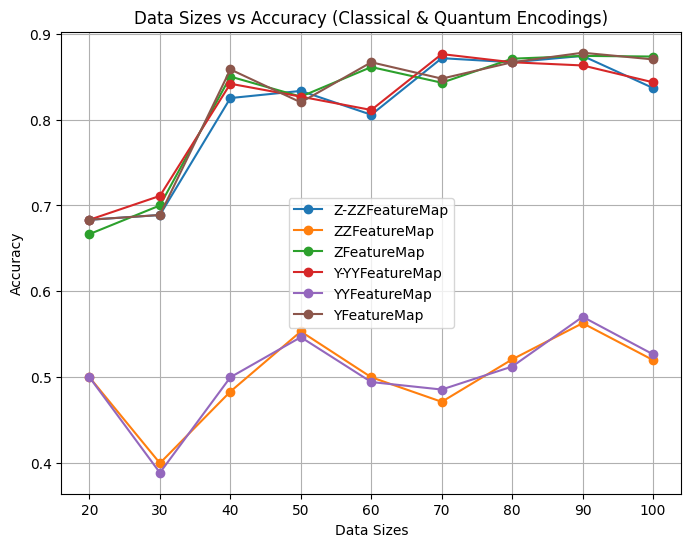

In [118]:
data_sizes, encodings, accuracies, times = zip(*results)
unique_encodings = list(dict.fromkeys(encodings))  

plt.figure(figsize=(8,6))

for option in unique_encodings:
    x_vals = [s for s, e in zip(data_sizes, encodings) if e == option]
    y_vals = [a for a, e in zip(accuracies, encodings) if e == option]

    plt.plot(x_vals, y_vals, 'o-', label=option)

plt.xlabel("Data Sizes")
plt.ylabel("Accuracy")
plt.title("Data Sizes vs Accuracy (Classical & Quantum Encodings)")
plt.legend()
plt.grid(True)
plt.show()

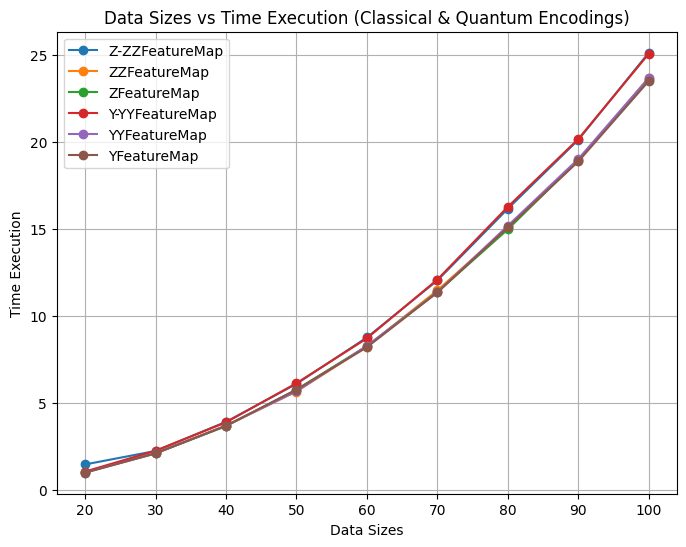

In [119]:
plt.figure(figsize=(8,6))

for option in unique_encodings:
    x_vals = [s for s, e in zip(data_sizes, encodings) if e == option]
    y_vals = [a for a, e in zip(times, encodings) if e == option]

    plt.plot(x_vals, y_vals, 'o-', label=option)

plt.xlabel("Data Sizes")
plt.ylabel("Time Execution")
plt.title("Data Sizes vs Time Execution (Classical & Quantum Encodings)")
plt.legend()
plt.grid(True)
plt.show()